In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

In [2]:
data_path = 'data/train.csv'

columns = ['timestamp', 'OZONE', 'NO2', 'temp', 'humidity', 'no2op1', 'no2op2', 'o3op1', 'o3op2']

raw = pd.read_csv(data_path, header=0, names=columns)


In [3]:
print(raw.head())

             timestamp  OZONE     NO2  temp  humidity  no2op1  no2op2  o3op1  \
0  2019-03-27 13:01:00  77.59   6.881  36.2      38.9   199.0   200.0  240.0   
1  2019-03-27 13:03:00  78.71  11.057  36.3      37.7   196.0   200.0  237.0   
2  2019-03-27 13:04:00  78.85   8.596  36.7      38.0   195.0   199.0  235.0   
3  2019-03-27 13:07:00  79.27   7.248  37.0      37.5   193.0   198.0  233.0   
4  2019-03-27 13:08:00  80.01   8.638  36.8      36.8   191.0   198.0  231.0   

   o3op2  
0  197.0  
1  196.0  
2  196.0  
3  195.0  
4  195.0  


In [28]:
df = raw.copy()
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)  # Biểu diễn chu kỳ 24h
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['weekend'] = (df['day_of_week'] >= 5).astype(int)  # Xác định cuối tuần
df = df.drop(columns=['timestamp', 'hour', 'day_of_week'])  # Xóa cột không cần thiết
print(df.head())

   OZONE     NO2  temp  humidity  no2op1  no2op2  o3op1  o3op2  sin_hour  \
0  77.59   6.881  36.2      38.9   199.0   200.0  240.0  197.0 -0.258819   
1  78.71  11.057  36.3      37.7   196.0   200.0  237.0  196.0 -0.258819   
2  78.85   8.596  36.7      38.0   195.0   199.0  235.0  196.0 -0.258819   
3  79.27   7.248  37.0      37.5   193.0   198.0  233.0  195.0 -0.258819   
4  80.01   8.638  36.8      36.8   191.0   198.0  231.0  195.0 -0.258819   

   cos_hour  weekend  
0 -0.965926        0  
1 -0.965926        0  
2 -0.965926        0  
3 -0.965926        0  
4 -0.965926        0  


### Import linear model đã được import từ task 1 để tạo baseline cho MAE

In [31]:
lr_model = LinearRegression()
X = df[['no2op1', 'no2op2', 'o3op1', 'o3op2', 'temp', 'humidity', 'sin_hour', 'cos_hour', 'weekend']]
Y_O3 = df['OZONE']
Y_NO2 = df['NO2']

cv_scores = cross_val_score(lr_model, X, Y_O3, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error', n_jobs=-1)
mae_o3 = -np.mean(cv_scores)    
print(f"MAE baseline O3: {mae_o3:.2f}")
cv_scores = cross_val_score(lr_model, X, Y_NO2, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error', n_jobs=-1)
mae_no2 = -np.mean(cv_scores)
print(f"MAE baseline NO2: {mae_no2:.2f}")


MAE baseline O3: 5.22
MAE baseline NO2: 6.46


### Tạo ra new feature

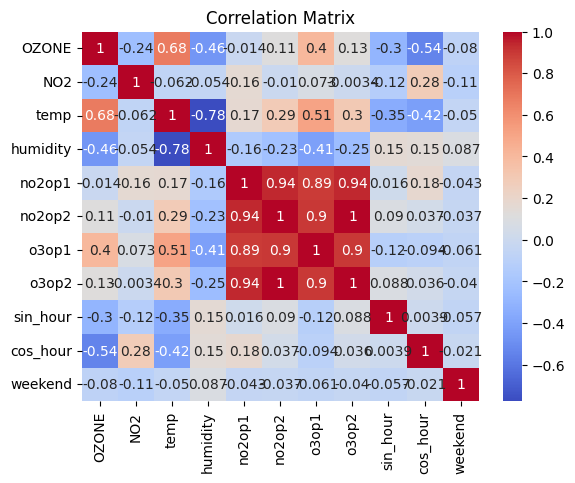

<Figure size 1000x2000 with 0 Axes>

In [32]:
# Kiểm tra độ tương quan giữa các model
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.figure(figsize=(10, 20))
plt.show()

In [33]:
# Có thể thấy các đặc trưng no2op1, no2op2, o3op1, o3op2 có độ tương quan cao với nhau, ngoài ra nhiệt độ và độ ẩm cũng có độ tương quan cao với nhau.
# Tạo các đặc trưng mới từ các đặc trưng có độ tương quan cao
df['temp_humidity_ratio'] = df['temp'] / (df['humidity'] + 1e-5)  # Tỷ lệ nhiệt độ/độ ẩm
df['temp * humidity'] = df['temp'] * df['humidity']  # Tích nhiệt độ và độ ẩm
df['no2op1 * no2op2'] = df['no2op1'] * df['no2op2']  # Tích các đặc trưng NO2
df['o3op1 * o3op2'] = df['o3op1'] * df['o3op2']  # Tích các đặc trưng O3
print(df.head())

   OZONE     NO2  temp  humidity  no2op1  no2op2  o3op1  o3op2  sin_hour  \
0  77.59   6.881  36.2      38.9   199.0   200.0  240.0  197.0 -0.258819   
1  78.71  11.057  36.3      37.7   196.0   200.0  237.0  196.0 -0.258819   
2  78.85   8.596  36.7      38.0   195.0   199.0  235.0  196.0 -0.258819   
3  79.27   7.248  37.0      37.5   193.0   198.0  233.0  195.0 -0.258819   
4  80.01   8.638  36.8      36.8   191.0   198.0  231.0  195.0 -0.258819   

   cos_hour  weekend  temp_humidity_ratio  temp * humidity  no2op1 * no2op2  \
0 -0.965926        0             0.930591          1408.18          39800.0   
1 -0.965926        0             0.962864          1368.51          39200.0   
2 -0.965926        0             0.965789          1394.60          38805.0   
3 -0.965926        0             0.986666          1387.50          38214.0   
4 -0.965926        0             1.000000          1354.24          37818.0   

   o3op1 * o3op2  
0        47280.0  
1        46452.0  
2        46

In [34]:
X = df[['no2op1', 'no2op2', 'o3op1', 'o3op2', 'temp', 'humidity', 'sin_hour', 'cos_hour', 'weekend', 'temp_humidity_ratio', 'temp * humidity', 'no2op1 * no2op2', 'o3op1 * o3op2']]
Y_O3 = df['OZONE']
Y_NO2 = df['NO2']

In [45]:
def evaluate_feature(X, Y, target):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, Y)
    lr_model = LinearRegression()
    lr_model.fit(X, Y)
    
    feature_importance = rf_model.feature_importances_
    features = X.columns
    
    plt.figure(figsize=(7, 3))
    plt.barh(features, feature_importance, color='skyblue')
    plt.title(f"Feature Importance for {target}")
    plt.xlabel("Importance Score")
    plt.show()
    
    crs_val = cross_val_score(lr_model, X, Y, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error')
    mean_crs_val = -np.mean(crs_val)
    print(f"Mean Cross-Validation MAE for {target}: {mean_crs_val}")

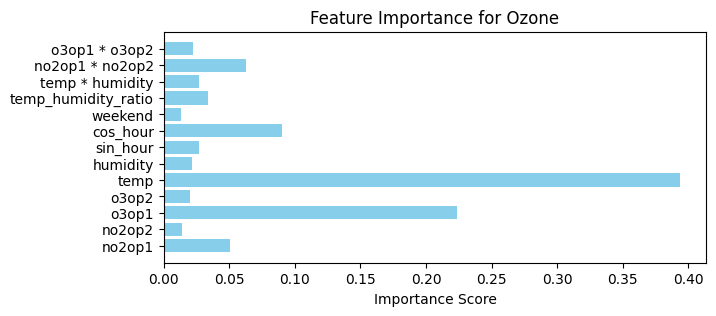

Mean Cross-Validation MAE for Ozone: 5.1072574527368975


In [46]:
evaluate_feature(X, Y_O3, 'Ozone')

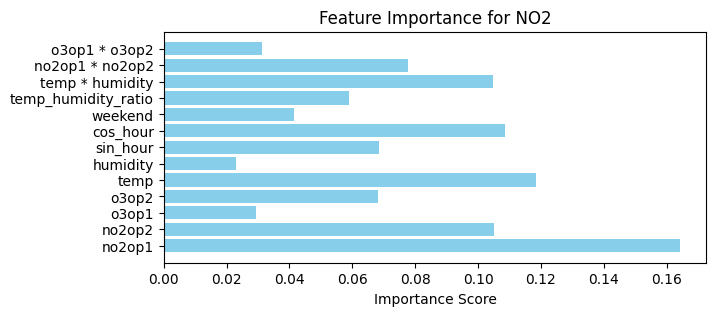

Mean Cross-Validation MAE for NO2: 6.34024884532837


In [47]:
evaluate_feature(X, Y_NO2, 'NO2')

Vậy có thể thấy những feature mới ta có thể lấy là temp x humidity và cos_hour. Vì bọn chúng có độ ảnh hưởng cao đến kết quả dự đoán cũng như không bị overfit vì chỉ số MAE thấp hơn so với baseline MAE của linear model. 

In [13]:
#Xóa các cột không cần thiết để hiệu suất train được tối ưu hơn
df = df.drop(columns=['sin_hour', 'weekend', 'o3op1 * o3op2', 'no2op1 * no2op2', 'temp_humidity_ratio'], errors='ignore')
print(df.head())

   OZONE     NO2  temp  humidity  no2op1  no2op2  o3op1  o3op2  cos_hour  \
0  77.59   6.881  36.2      38.9   199.0   200.0  240.0  197.0 -0.965926   
1  78.71  11.057  36.3      37.7   196.0   200.0  237.0  196.0 -0.965926   
2  78.85   8.596  36.7      38.0   195.0   199.0  235.0  196.0 -0.965926   
3  79.27   7.248  37.0      37.5   193.0   198.0  233.0  195.0 -0.965926   
4  80.01   8.638  36.8      36.8   191.0   198.0  231.0  195.0 -0.965926   

   temp * humidity  
0          1408.18  
1          1368.51  
2          1394.60  
3          1387.50  
4          1354.24  


In [48]:
# Khởi tạo các model phi tuyến
decision_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
knn = KNeighborsRegressor(n_neighbors=5)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
neural_net = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42)

models = {
    "Decision Tree": decision_tree,
    "KNN": knn,
    "SVR": svr,
    "Neural Network": neural_net
}

In [49]:
cv_results_no2 = {}
cv_results_o3 = {}
X_train = df[['no2op1', 'no2op2', 'o3op1', 'o3op2', 'temp', 'humidity', 'cos_hour','temp * humidity']]
Y_NO2_train = df['NO2']
Y_O3_train = df['OZONE']


In [50]:
print("Kết quả mae cho NO2 của các model phi tuyến:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, Y_NO2_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error', n_jobs=-1)
    avg_mae = -np.mean(cv_scores)
    cv_results_no2[name] = avg_mae
    print(f"{name}: MAE = {avg_mae:.4f}")

Kết quả mae cho NO2 của các model phi tuyến:
Decision Tree: MAE = 5.4856
KNN: MAE = 3.6355
SVR: MAE = 6.7084
Neural Network: MAE = 5.7282


In [51]:
print("\nKết quả mae cho OZONE của các model phi tuyến:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, Y_O3_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error', n_jobs=-1)
    avg_mae = -np.mean(cv_scores)
    cv_results_o3[name] = avg_mae
    print(f"{name}: MAE = {avg_mae:.4f}")


Kết quả mae cho OZONE của các model phi tuyến:
Decision Tree: MAE = 7.1551
KNN: MAE = 4.6702
SVR: MAE = 11.6294
Neural Network: MAE = 5.7195


In [ ]:
# Các model ensemble
random_forest = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
voting = VotingRegressor(estimators=[('rf', random_forest), ('xgb', xgb)], weights=[1, 1])

models = {
    'Random Forest': random_forest,
    'XGBoost': xgb,
    'Voting Regressor': voting,
}

In [57]:
print("\nKết quả mae cho NO2 của các model ensemble:") 
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, Y_NO2_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error', n_jobs=-1)
    avg_mae = -np.mean(cv_scores)
    cv_results_no2[name] = avg_mae
    print(f"{name}: MAE = {avg_mae:.4f}")


Kết quả mae cho NO2 của các model ensemble:
Random Forest: MAE = 2.3420
XGBoost: MAE = 3.2315
Voting Regressor: MAE = 2.6565


In [58]:
print("\nKết quả mae cho OZONE của các model ensemble:")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, Y_O3_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error', n_jobs=-1)
    avg_mae = -np.mean(cv_scores)
    cv_results_o3[name] = avg_mae
    print(f"{name}: MAE = {avg_mae:.4f}")


Kết quả mae cho OZONE của các model ensemble:
Random Forest: MAE = 3.4317
XGBoost: MAE = 3.9779
Voting Regressor: MAE = 3.5492


In [25]:
# Các model hybrid
# Staking Regressor
stacking_model = StackingRegressor(
    estimators=[
        ('dt', DecisionTreeRegressor(max_depth=5)),
        ('knn', KNeighborsRegressor(n_neighbors=5))
    ],
    final_estimator=LinearRegression()
)

cv_scores = cross_val_score(stacking_model, X_train, Y_NO2_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error')
avg_mae = -np.mean(cv_scores)
print(f"Stacking Regressor NO2 - MAE: {avg_mae:.4f}")
cv_scores = cross_val_score(stacking_model, X_train, Y_O3_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error')
avg_mae = -np.mean(cv_scores)
print(f"Stacking Regressor O3 - MAE: {avg_mae:.4f}")
# Voting Regressor

Stacking Regressor NO2 - MAE: 7.5609
Stacking Regressor O3 - MAE: 6.7129


In [26]:
#Cascade Learning
lr_model = LinearRegression()
lr_model.fit(X_train, Y_NO2_train)
lr_pred = lr_model.predict(X_train)

X_train_enhanced = X_train.copy()
X_train_enhanced['lr_pred'] = lr_pred
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

cv_scores = cross_val_score(rf_model, X_train_enhanced, Y_NO2_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error')
avg_mae = -np.mean(cv_scores)
print(f"Cascade Learning NO2 - MAE: {avg_mae:.4f}")
cv_scores = cross_val_score(rf_model, X_train_enhanced, Y_O3_train, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring='neg_mean_absolute_error')
avg_mae = -np.mean(cv_scores)
print(f"Cascade Learning O3 - MAE: {avg_mae:.4f}")


Cascade Learning NO2 - MAE: 2.7484
Cascade Learning O3 - MAE: 3.4755


### Có thể thấy sau khi train qua các model thì model Random Forest cho độ chính xác cao nhất nên ta sẽ chọn

In [61]:
# Ta tiến hành kỹ thuật grid search để tìm ra những tham số tối ưu cho Random forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

grid_search.fit(X_train, Y_NO2_train)
print("Tham số tối ưu cho Random Forest model dự đoán NO2:", grid_search.best_params_)
print("MAE tối ưu cho Random Forest model dự đoán NO2:", -grid_search.best_score_)
grid_search.fit(X_train, Y_O3_train)
print("Tham số tối ưu cho Random Forest model dự đoán O3:", grid_search.best_params_)
print("MAE tối ưu cho Random Forest model dự đoán O3:", -grid_search.best_score_)

OSError: [Errno 22] Invalid argument